In [35]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from trialblazer.models import (
    get_morgan2,
    compute_2Drdkit,
    MLP_simulation_test,
    MLP_cv,
    MLP_decision_threshold_optimization,
    RF_cv,
    feature_selection
)
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
Training_data = pd.read_csv("../Data/Training_data_withoutInfo.csv", sep='|')
Target_features = pd.read_csv('../Data/training_target_features.csv')

# Descriptors

## Predicted bioactivity fingerprints (PBFPs)

In [38]:
active_targets_merged_forlist = Target_features.drop(columns=['SmilesForDropDu'])
targets_list = list(active_targets_merged_forlist.columns)
print(len(targets_list))

768


In [39]:
Training_data = Training_data.merge(Target_features, how='left',on='SmilesForDropDu')
Training_data[targets_list].isna().any().sum()

np.int64(0)

## Morgan2 fingerprints (M2FPs)

In [40]:
Training_data.Molecule = Training_data.SmilesForDropDu.apply(Chem.MolFromSmiles)
Training_data['fp'] = Training_data.Molecule.apply(get_morgan2)
morgan2_cols = ['morgan2_b'+ str(i) for i in list(range(2048))]
Training_data[morgan2_cols] = Training_data['fp'].to_list()

## Physicochemical descriptors (PCD)

If you are not using PCD, don't need to run this section, becuase it will remove one datapoint from Trianing_data

In [18]:
descriptors_list = [x[0] for x in Descriptors._descList]
print(len(descriptors_list))

In [19]:
Training_data.Molecule = Training_data.SmilesForDropDu.apply(Chem.MolFromSmiles)
Training_data['desc'] = Training_data.Molecule.apply(compute_2Drdkit)

In [20]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
desc_cols = list(calc.GetDescriptorNames())
Training_data[desc_cols] = Training_data.desc.to_list()
Training_data.drop("desc",axis=1,inplace=True)

In [ ]:
Training_data[desc_cols].dropna(inplace=True)
Training_data[desc_cols].isnull().values.any()

In [ ]:
Training_data[desc_cols][Training_data[desc_cols].isna().any(axis=1)] # somehow dropna didn't remove this.

In [ ]:
Training_data.iloc[1272,:]

In [ ]:
Training_data.drop(labels=1272, axis=0,inplace=True)
Training_data.reset_index(inplace=True)

# 10-fold cross validation

## model based on 208 physicochemical descriptors

In [ ]:
X = Training_data[desc_cols]
y = Training_data.Mark

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

MLP

In [ ]:
MLP_cv(X_scaled,y)

## model based on M2FPs

In [41]:
X = Training_data[morgan2_cols]
y = Training_data.Mark

MLP

In [ ]:
opt_threshold_ap, opt_threshold_mean = MLP_decision_threshold_optimization(
    X,
    y,
    opt_num_feature=750
    ) 

Mean MCC: 0.437 ± 0.137
Mean balanced accuracy: 0.782 ± 0.082
Mean recall: 0.764 ± 0.115
Mean precision: 0.383 ± 0.100
Mean AUC: 0.867 ± 0.067


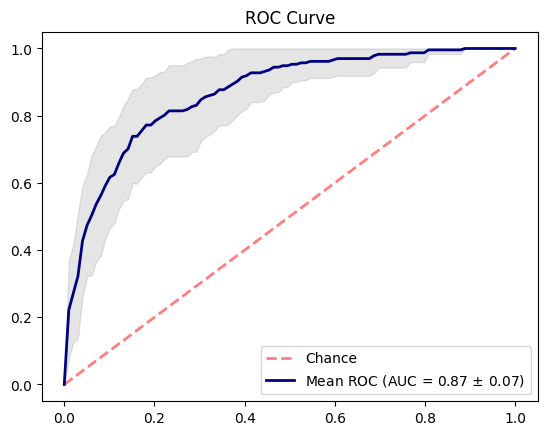

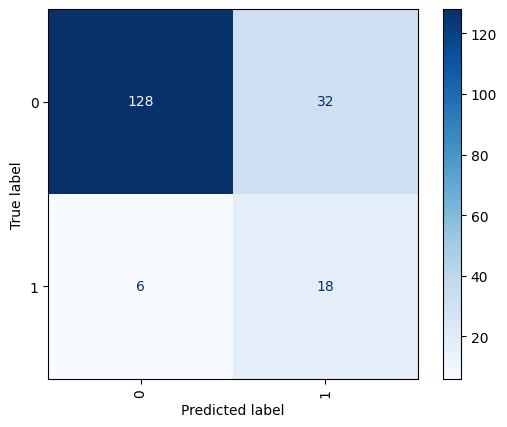

In [42]:
MLP_cv(np.array(X),y,opt_num_feature=750,threshold=0.12)

## model based on M2FPs+PBFPs

In [43]:
M2FPs_PBFPs =  morgan2_cols + targets_list
len(M2FPs_PBFPs)

2816

In [44]:
X = Training_data[M2FPs_PBFPs]
y = Training_data.Mark

In [ ]:
opt_threshold_ap, opt_threshold_mean = MLP_decision_threshold_optimization(
    X,
    y,
    opt_num_feature=850)

Mean MCC: 0.469 ± 0.136
Mean balanced accuracy: 0.789 ± 0.079
Mean recall: 0.739 ± 0.135
Mean precision: 0.428 ± 0.113
Mean AUC: 0.873 ± 0.067


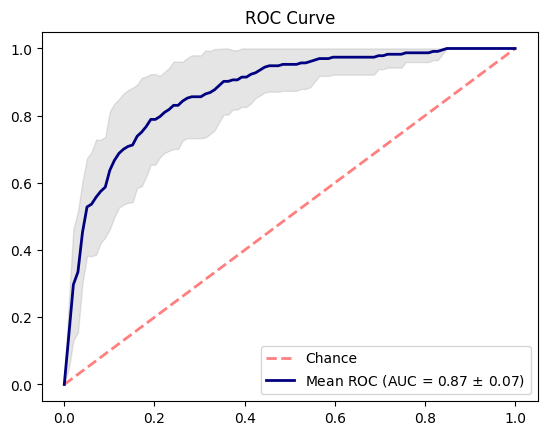

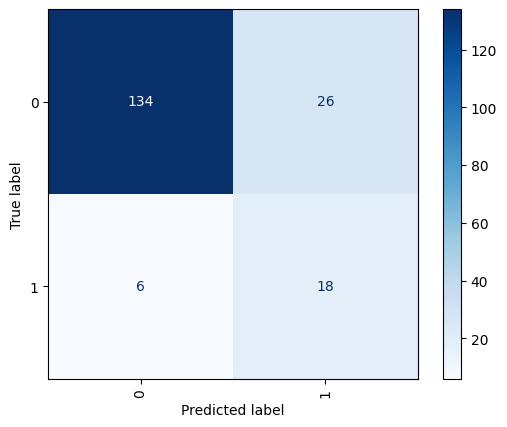

In [45]:
MLP_cv(np.array(X),y, opt_num_feature=850, threshold=0.15)

# Simulation tests

In [ ]:
X = Training_data[M2FPs_PBFPs]
selector = SelectKBest(f_classif, k=850)
X_new = selector.fit_transform(X, y)

In [ ]:
k_fold_mccs = []
for iter in tqdm(range(1, 10001)): 
    k_fold_mccs.append(MLP_simulation_test(X_new,y))

In [ ]:
plt.hist(k_fold_mccs, bins=100);
plt.xlabel('MCC', fontsize = 10) 
plt.ylabel('Count',fontsize = 10) 
plt.title('Simulation test')
plt.axvline(x = 0.47, color = 'b',lw=2,label = 'MCC of MLP based on\nM2FPs+PBFPs = 0.47')
plt.axvline(x = 0.44, color = 'r',lw=2,label = 'MCC of MLP based on\nM2FP = 0.44')
plt.axvline(x = 0.09, color = 'g',lw=2,label = 'MCC of MLP based on\nGIN = 0.09')
plt.axvline(x = 0.17, color = 'm',lw=2,label = 'MCC of MLP based on\nChemBERTa = 0.17')
plt.legend(loc='upper right')

# Hyperparameter optimization

MLP

In [ ]:
X = Training_data[M2FPs_PBFPs]
y = Training_data.Mark
selector = SelectKBest(f_classif, k=850)
X_new = selector.fit_transform(X, y)

param_grid = {
    'hidden_layer_sizes':[(10,),(20,),(30,),(40,),(50,),(60,),(70,),(80,),(90,),(100,)],
    'learning_rate_init':[0.0001,0.001,0.01,0.1],
    'random_state':[42],
    'max_iter':[200, 400, 600, 800]
    }
MLP = MLPClassifier()
grid_search = GridSearchCV(
    estimator = MLP, 
    param_grid = param_grid, 
    scoring='roc_auc',
    cv = 10)
grid_search.fit(X_new, y)
grid_search.best_params_

# Feature selecttion (K value optimization)

Example of model based on M2FPs+PBFPs features

initial

In [ ]:
X = Training_data[M2FPs_PBFPs]
y = Training_data.Mark
ANOVA_K_list = ['100','500','1000','1500','2000']
feature_selection(X, y, M2FPs_PBFPs,'M2FPs + PBFPs', ANOVA_K_list) 

extended

In [ ]:

ANOVA_K_list = ['500','550','600','650','700','750','800','850','900','950','1000']
feature_selection(X, y, M2FPs_PBFPs,'M2FPs + PBFPs', ANOVA_K_list) 